# Wavelet Transform and Run-Length Encoding
## 1. Import libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pywt
from pywt import wavedec
import numpy as np
import pandas as pd
from scipy.stats import iqr
import sys
import copy 
import pickle

## 2. Define constants

In [ ]:
#define the sampling rate
FS = 1000

#define the number of samples of data to compress
NUM_SAMPLES = 2830000 

#dictionary of lengths of coefficient matrices
#will be updated based on actual lengths
COEFF_LENGTHS = {'cA5': 100, 'cD5': 100, 'cD4': 100, 'cD3': 100, 'cD2': 100, 'cD1': 100}

#number of bits that can be used to represent the run length. a 5 bit number corresponds to 
#a max value of 2**5-1 = 31 bits, which is equal to 2147483648. so in other words, if the entire
#binary map was all 1 or all 0, NUM_BITS_RUN_LEN=5 means we can represent a run of 2147483648
#consecutive 0's or 1's
NUM_BITS_RUN_LEN = 4

#don't allow the PRD to be greater than 0.5
MAX_PRD = 0.5

#define PRD0 = 70-80% of the required PRD = target PRD before quantization
#separate percentage for approximate and detailed coefficients
PRD0_APPROX = 0.4
PRD0_D5 = 0.3
PRD0_D4_D1 = 0.2

#quantization parameter for mid-tread uniform quantizer
Q_PARAM = 32 # not needed since above quantizer not used

## 3. Define functions  

### wavelet decomposition
*The wavelet used in this algorithm is bior4.4, with 5 levels of decomposition.*

In [3]:
def wavelet_decomposition(sig, do_plot):
    cA5, cD5, cD4, cD3, cD2, cD1 = wavedec(sig, 'bior4.4', level=5)
    coeffs = {'cA5': cA5, 'cD5': cD5, 'cD4': cD4, 'cD3': cD3, 'cD2': cD2, 'cD1': cD1}

    if do_plot:
        print('Plot of wavelet decomposition for all levels')
        plt.subplots(figsize=(16,9))

        plt.subplot(6,1,1)
        plt.plot(coeffs['cA5'])
        plt.title('cA5')
        plt.xlim(374000,376000)

        plt.subplot(6,1,2)
        plt.plot(coeffs['cD5'])
        plt.title('cD5')
        plt.xlim(374000,376000)

        plt.subplot(6,1,3)
        plt.plot(coeffs['cD4'])
        plt.title('cD4')
        plt.xlim(374000,376000)

        plt.subplot(6,1,4)
        plt.plot(coeffs['cD3'])
        plt.title('cD3')
        plt.xlim(374000,376000)

        plt.subplot(6,1,5)
        plt.plot(coeffs['cD2'])
        plt.title('cD2')
        plt.xlim(374000,376000)

        plt.subplot(6,1,6)
        plt.plot(coeffs['cD1'])
        plt.title('cD1')
        plt.xlim(374000,376000)
        plt.xlabel('Index')

        plt.tight_layout()
        plt.show()

    return coeffs

### wavelet reconstruction
*the wavelet is bior4.4 with 5 levels of decomposition*

In [4]:
def wavelet_reconstruction(coeffs, orig_data, CR, do_plot=False):
    reconstructed = pywt.waverec([coeffs['cA5'], coeffs['cD5'], coeffs['cD4'], coeffs['cD3'], 
                                    coeffs['cD2'], coeffs['cD1']], 'bior4.4')


    if do_plot:
        print('Plot of original signal through the process of compression and decompression:')
        
        t = [i/FS for i in range(NUM_SAMPLES)]
        plt.subplots(figsize=(16,9))
        plt.plot(t, orig_data, label='Original Signal')
        plt.plot(t, reconstructed, label='Reconstructed Signal')
        #plt.title('Compression Ratio: %.1f' % CR)
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude (mV)')
        plt.tight_layout()
        plt.legend(loc=1)
        axes = plt.gca()
        axes.set_xlim((17, 21.5))
        plt.show()

    return reconstructed

### threshold wavelet coefficients to a percentage of total energy
*Different levels of decomposition are thresholded at different energy percentages.*  
1. calculate the energy of all the coefficients
1. compute threshold for each coefficient matrix
1. keep corresponding coefficients that are above the threshold

In [5]:
def threshold_energy(coeffs, do_plot=False):
    #make a deep copy of coeffs to retain the original version
    coeffs_orig = copy.deepcopy(coeffs)

    binary_map = {}
    nonzero_coeff_count = {}

    for key in coeffs.keys():
        #sort the absolute value of the coefficients in ascending order
        tmp_coeffs = np.sort(np.abs(coeffs[key]),axis=0)
        #get indices of sorted coefficients in original list
        ic = np.argsort(np.abs(coeffs[key]),axis=0)

        #calculate the threshold for retaining some percentage of the largest coefficients
        if key == 'cA5':
            PRD0 = PRD0_APPROX
        elif key == 'cD5':
            PRD0 = PRD0_D5
        else:
            PRD0 = PRD0_D4_D1
          
        #find indices of coefficients below the threshold
        temp1d = np.swapaxes(tmp_coeffs,0,1)[0]
        tol = PRD0*np.linalg.norm(temp1d,2)/100
        nerror = np.cumsum(tmp_coeffs**2,axis=0)
        
        #-----------------
        #KEEP COEFFICIENTS
        #thresh_ind = np.unique(np.where(nerror >= tol**2)[0])
        #keep_ind = np.swapaxes(ic[thresh_ind],0,1)[0]
        #keep_ind = np.sort(keep_ind)
        
        #remove any coefficients below the threshold
        #tmp_coeffs = coeffs[key]
        #tmp_coeffs = tmp_coeffs[keep_ind]
        
        #create the binary map
        #binary_map_tmp = np.zeros(len(coeffs[key])).astype(int)
        #binary_map_tmp[keep_ind] = 1
        #-----------------

        #-----------------
        #DELETE COEFFICIENTS
        #find indices of coefficients below threshold
        delete_ind = np.unique(np.where(nerror < tol**2)[0])
        delete_ind = np.swapaxes(ic[delete_ind],0,1)[0]
        del_ind = np.sort(delete_ind)
        
        #set coefficients below threshold to zero
        tmp_coeffs = coeffs[key]
        tmp_coeffs[del_ind] = 0

        #create the binary map
        binary_map_tmp = np.ones(len(coeffs[key])).astype(int)
        binary_map_tmp[del_ind] = 0
        #-----------------

        
        #update the various dictionaries
        coeffs[key] = tmp_coeffs
        binary_map[key] = binary_map_tmp
        nonzero_coeff_count[key] = len(tmp_coeffs)


    if do_plot:
        print('Plot of thresholded vs unthresholded coefficients:')
        plt.subplots(figsize=(16,9))

        plt.subplot(6,1,1)
        plt.plot(coeffs_orig['cA5'], label='Original')
        plt.plot(coeffs['cA5'], label='Thresholded')
        plt.legend(loc=1)
        plt.xlim(374000,376000)
        plt.title('cA5')

        plt.subplot(6,1,2)
        plt.plot(np.swapaxes(coeffs_orig['cD5'],0,1)[0], label='Original')
        plt.plot(np.swapaxes(coeffs['cD5'],0,1)[0], label='Thresholded')
        plt.legend(loc=1)
        plt.xlim(374000,376000)
        plt.title('cD5')

        plt.subplot(6,1,3)
        plt.plot(coeffs_orig['cD4'], label='Original')
        plt.plot(coeffs['cD4'], label='Thresholded')
        plt.legend(loc=1)
        plt.xlim(374000,376000)
        plt.title('cD4')

        plt.subplot(6,1,4)
        plt.plot(coeffs_orig['cD3'], label='Original')
        plt.plot(coeffs['cD3'], label='Thresholded')
        plt.legend(loc=1)
        plt.xlim(374000,376000)
        plt.title('cD3')

        plt.subplot(6,1,5)
        plt.plot(coeffs_orig['cD2'], label='Original')
        plt.plot(coeffs['cD2'], label='Thresholded')
        plt.legend(loc=1)
        plt.xlim(374000,376000)
        plt.title('cD2')

        plt.subplot(6,1,6)
        plt.plot(coeffs_orig['cD1'], label='Original')
        plt.plot(coeffs['cD1'], label='Thresholded')
        plt.legend(loc=1)
        plt.xlim(374000,376000)
        plt.xlabel('Index')

        plt.tight_layout()
        plt.show()

    return coeffs, binary_map

### scale the wavelet coefficients to the [0,1] range
*two scaling factors: a shift factor and a multiplication factor*

In [6]:
def scale_coeffs(coeffs, do_plot=False):
    coeffs_scaled = {}
    scaling_factors = {}

    for key in coeffs.keys():
        shift_factor = np.min(coeffs[key])
        coeffs_tmp = coeffs[key]-shift_factor

        scale_factor = np.max(coeffs_tmp)
        coeffs_tmp = coeffs_tmp/scale_factor

        scaling_factors[key] = {'shift_factor': shift_factor, 'scale_factor': scale_factor}
        coeffs_scaled[key] = coeffs_tmp


    if do_plot:
        print('Plot of scaled coefficients:')
        plt.subplots(figsize=(16,9))

        plt.subplot(6,1,1)
        plt.plot(coeffs_scaled['cA5'])
        plt.title('cA5')

        plt.subplot(6,1,2)
        plt.plot(coeffs_scaled['cD5'])
        plt.title('cD5')

        plt.subplot(6,1,3)
        plt.plot(coeffs_scaled['cD4'])
        plt.title('cD4')

        plt.subplot(6,1,4)
        plt.plot(coeffs_scaled['cD3'])
        plt.title('cD3')

        plt.subplot(6,1,5)
        plt.plot(coeffs_scaled['cD2'])
        plt.title('cD2')

        plt.subplot(6,1,6)
        plt.plot(coeffs_scaled['cD1'])
        plt.title('cD1')
        plt.xlabel('Index')

        plt.tight_layout()
        plt.show()

    return coeffs_scaled, scaling_factors

### unscale the coefficients back to their original scaling

In [7]:
def unscale_coeffs(coeffs_orig, coeffs_reconstructed, scaling_factors, bits, do_plot=False):
    coeffs_unscaled = {}

    for key in coeffs_reconstructed.keys():
        tmp_coeffs_unscaled = coeffs_reconstructed[key]/(2**bits)
        tmp_coeffs_unscaled = tmp_coeffs_unscaled*scaling_factors[key]['scale_factor']
        tmp_coeffs_unscaled = tmp_coeffs_unscaled + scaling_factors[key]['shift_factor']

        #now replace the NaN values with 0
        nan_inds = np.where(np.isnan(tmp_coeffs_unscaled))[0]
        tmp_coeffs_unscaled[nan_inds] = 0

        coeffs_unscaled[key] = tmp_coeffs_unscaled


    if do_plot:
        print('Plot of wavelet coefficients before scaling and after rescaling:')
        plt.subplots(figsize=(16,9))

        plt.subplot(6,1,1)
        plt.plot(coeffs_orig['cA5'], label='Before Scaling')
        plt.plot(coeffs_unscaled['cA5'], label='After Rescaling')
        plt.legend(loc=1)
        plt.title('cA5')

        plt.subplot(6,1,2)
        plt.plot(coeffs_orig['cD5'], label='Before Scaling')
        plt.plot(coeffs_unscaled['cD5'], label='After Rescaling')
        plt.legend(loc=1)
        plt.title('cD5')

        plt.subplot(6,1,3)
        plt.plot(coeffs_orig['cD4'], label='Before Scaling')
        plt.plot(coeffs_unscaled['cD4'], label='After Rescaling')
        plt.legend(loc=1)
        plt.title('cD4')

        plt.subplot(6,1,4)
        plt.plot(coeffs_orig['cD3'], label='Before Scaling')
        plt.plot(coeffs_unscaled['cD3'], label='After Rescaling')
        plt.legend(loc=1)
        plt.title('cD3')

        plt.subplot(6,1,5)
        plt.plot(coeffs_orig['cD2'], label='Before Scaling')
        plt.plot(coeffs_unscaled['cD2'], label='After Rescaling')
        plt.legend(loc=1)
        plt.title('cD2')

        plt.subplot(6,1,6)
        plt.plot(coeffs_orig['cD1'], label='Before Scaling')
        plt.plot(coeffs_unscaled['cD1'], label='After Rescaling')
        plt.legend(loc=1)
        plt.xlabel('Index')

        plt.tight_layout()
        plt.show()

    return coeffs_unscaled

### calculate the lowest possible number of bits to quantize the wavelet coefficients such that the PRD is above the threshold
1. quantize the signal starting at 8 bits
1. unquantize and reconstruct the signal
1. calculate the PRD. Repeat with 1 fewer bit (ie, 7 bits)
1. repeat

In [8]:
def calculate_num_bits(orig_sig, coeffs_scaled, binary_map, scaling_factors, do_plot=False):
    #starting at 8 bits, keep decreasing the number of bits in the quantization
    #until the PRD is above some threshold
    num_bits = 9

    #initialize PRD to 0 so the while loop can run
    PRD = 0

    #keep track of PRD per number of bits
    PRD_dict = {}

    if do_plot:
        plt.subplots(figsize=(16,9))
        t = [i/FS for i in range(NUM_SAMPLES)]
        plt.plot(t, orig_sig, label='Original Signal')


    while (num_bits >= 5) and (PRD <= MAX_PRD):
        #decrement the number of bits
        num_bits = num_bits-1

        coeffs_quantized = do_quantization(coeffs_scaled, num_bits)

        #rescale the coefficients
        coeffs_unscaled = unscale_coeffs(None, coeffs_quantized, scaling_factors, num_bits)

        #inverse wavelet transform
        data_reconstructed = wavelet_reconstruction(coeffs_unscaled, None, None)
        data_reconstructed = np.delete(data_reconstructed,1,axis=1)
        
        #calculate PRD
        PRD = calculate_PRD(orig_sig, data_reconstructed)
        PRD_dict[num_bits] = PRD

        #plot the reconstructed signals 
        if do_plot:
            if PRD <= MAX_PRD:
                plt.plot(t, data_reconstructed, label='Reconstructed @ %i Bits, PRD = %.2f' % (num_bits, PRD))

    #if PRD exceeds set maximum, re-increment num_bits
    if PRD > MAX_PRD:
        num_bits = num_bits+1
        PRD = PRD_dict[num_bits]

    #plot
    if do_plot:
        print('Plots of reconstructed signals vs number of bits used for quantization:')
        plt.legend(loc=1)
        plt.tight_layout()
        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude (mV)')
        axes = plt.gca()
        axes.set_xlim((17, 21.5))
        axes.set_ylim((-2000,2000))
        plt.show()


    return num_bits, PRD

### combine all the wavelet coefficients into one continuous array
*done for each decomposition level and for binary map*

In [9]:
def combine_coefficients(coeffs, binary_map=None):
    coeffs_combined = []

    #loop through each of the wavelet decompositions
    #(or coefficient matrices) and remove all zero values
    #based on the binary map
    if binary_map is not None:
        for key in coeffs.keys():
            inds_to_keep = np.where(binary_map[key]==1)[0]
            coeffs[key] = coeffs[key][inds_to_keep]

    #add each array to coeffs_combined
    coeffs_combined.extend(coeffs['cA5'])
    coeffs_combined.extend(coeffs['cD5'])
    coeffs_combined.extend(coeffs['cD4'])
    coeffs_combined.extend(coeffs['cD3'])
    coeffs_combined.extend(coeffs['cD2'])
    coeffs_combined.extend(coeffs['cD1'])

    return coeffs_combined

### map the wavelet coefficients (and the binary map) back to their original decomposition levels
*necessary prerequisite for reconstruction of the time domain waveform*

In [10]:
def remap_coeffs(coeffs, binary_map):
    coeffs_remapped = np.zeros(len(binary_map))*np.nan
    inds_to_set = np.where(binary_map==1)[0]
    coeffs_remapped[inds_to_set] = coeffs

    wavelet_remapped = {}
    counter = 0
    wavelet_remapped['cA5'] = coeffs_remapped[counter:counter+COEFF_LENGTHS['cA5']]

    counter = counter + COEFF_LENGTHS['cA5']
    wavelet_remapped['cD5'] = coeffs_remapped[counter:counter+COEFF_LENGTHS['cD5']]

    counter = counter + COEFF_LENGTHS['cD5']
    wavelet_remapped['cD4'] = coeffs_remapped[counter:counter+COEFF_LENGTHS['cD4']]

    counter = counter + COEFF_LENGTHS['cD4']
    wavelet_remapped['cD3'] = coeffs_remapped[counter:counter+COEFF_LENGTHS['cD3']]

    counter = counter + COEFF_LENGTHS['cD3']
    wavelet_remapped['cD2'] = coeffs_remapped[counter:counter+COEFF_LENGTHS['cD2']]

    counter = counter + COEFF_LENGTHS['cD2']
    wavelet_remapped['cD1'] = coeffs_remapped[counter:counter+COEFF_LENGTHS['cD1']]

    return wavelet_remapped

### mid-tread uniform quantizer
*input: the selected largest wavelet coefficients*  

In [11]:
import math

def midtread_uniform_quantizer(coeffs, do_plot=False):
    quantized_coeffs = {}
    
    for key in coeffs.keys():
        out = np.multiply(np.sign(coeffs[key]),np.floor(np.abs(coeffs[key])/Q_PARAM + 0.5))
        quantized_coeffs[key] = out
        
    if do_plot:
        print('Plot of quantized coefficients:')
        plt.subplots(figsize=(16,9))

        plt.subplot(6,1,1)
        plt.plot(quantized_coeffs['cA5'])
        plt.title('cA5')

        plt.subplot(6,1,2)
        plt.plot(quantized_coeffs['cD5'])
        plt.title('cD5')

        plt.subplot(6,1,3)
        plt.plot(quantized_coeffs['cD4'])
        plt.title('cD4')

        plt.subplot(6,1,4)
        plt.plot(quantized_coeffs['cD3'])
        plt.title('cD3')

        plt.subplot(6,1,5)
        plt.plot(quantized_coeffs['cD2'])
        plt.title('cD2')

        plt.subplot(6,1,6)
        plt.plot(quantized_coeffs['cD1'])
        plt.title('cD1')
        plt.xlabel('Index')

        plt.tight_layout()
        plt.show()

        
    return quantized_coeffs

In [12]:
def do_quantization(coeffs, bits, do_plot=False):
    quantized_coeffs = {}

    for key in coeffs.keys():
        sig = coeffs[key]
        sig = sig*(2**bits-1)
        sig = np.round(sig)
        sig = np.array(sig).astype(int)

        quantized_coeffs[key] = sig


    if do_plot:
        print('Plot of quantized coefficients:')
        plt.subplots(figsize=(16,9))

        plt.subplot(6,1,1)
        plt.plot(quantized_coeffs['cA5'])
        plt.title('cA5')

        plt.subplot(6,1,2)
        plt.plot(quantized_coeffs['cD5'])
        plt.title('cD5')

        plt.subplot(6,1,3)
        plt.plot(quantized_coeffs['cD4'])
        plt.title('cD4')

        plt.subplot(6,1,4)
        plt.plot(quantized_coeffs['cD3'])
        plt.title('cD3')

        plt.subplot(6,1,5)
        plt.plot(quantized_coeffs['cD2'])
        plt.title('cD2')

        plt.subplot(6,1,6)
        plt.plot(quantized_coeffs['cD1'])
        plt.title('cD1')
        plt.xlabel('Index')

        plt.tight_layout()
        # plt.savefig('figs/wavelet_quantized.png', dpi=150)
        plt.show()

        
    return quantized_coeffs

### compress the wavelet coefficients
*combine bits into bytes*

In [13]:
def compress_coefficients(coeffs, num_bits):

    binary_string = ''

    for coeff in coeffs:
        #convert each coefficient value to binary in num_bits number of bits
        binary_string = binary_string + format(coeff[0], '0%ib' % num_bits)

    #loop through sets of 8 bits in the binary string and convert to a byte
    byte_array = []
    for i in range(int(len(binary_string)/8)):
        byte_tmp = binary_string[i*8:(i+1)*8]
        byte_tmp = int(byte_tmp, 2)
        byte_array.append(byte_tmp)

    #check if there are any remaining bits that don't divide evenly into 8
    #the number of bits in this last byte is required for decompression
    num_bits_last_byte = 8
    if len(binary_string)%8 != 0:
        byte_tmp = binary_string[(i+1)*8:(i+1)*8 + len(binary_string)%8]
        num_bits_last_byte = len(byte_tmp)
        byte_tmp = int(byte_tmp, 2)
        byte_array.append(byte_tmp)

    return byte_array, num_bits_last_byte


### decompress the previously compressed wavelet coefficients

In [14]:
def decompress_coefficients(coeffs_compressed, num_bits, num_bits_last_byte):

    binary_string = ''

    #convert each coefficient value to binary in 8 number of bits
    #note: if final value in the the binary map is not 8 bits,
    #use num_bits_last_byte to convert appropriately
    coeffs_len = len(coeffs_compressed)
    for i in range(coeffs_len):
        if i == coeffs_len-1:
            binary_string = binary_string + format(coeffs_compressed[i], '0%ib' % num_bits_last_byte)
        else:
            binary_string = binary_string + format(coeffs_compressed[i], '08b')


    #loop through sets of num_bits bits in the binary string and convert to a byte
    byte_array = []
    for i in range(int(len(binary_string)/num_bits)):
        byte_tmp = binary_string[i*num_bits:(i+1)*num_bits]
        byte_tmp = int(byte_tmp, 2)
        byte_tmp = [byte_tmp]*8
        byte_array.append(byte_tmp)


    return byte_array

### compress the binary map using variable length run-length encoding (RLE)

In [15]:
def compress_binary_map(binary_map):
    #loop through each entry in the binary map and compress

    #the last run count won't be included in the compressed representation, so 
    #just append one more value at the end of the binary map to trigger the last 
    #compression value. 
    #make a local deep copy so that the original is not affected
    binary_map = copy.deepcopy(binary_map)
    binary_map.append(int(not binary_map[-1]))


    CURRENT_STATE = binary_map[0]
    run_count = 0
    binary_string = ''

    #loop through each value in the binary map
    for val in binary_map:

        #if the current binary map value == previous one, increment the run count
        if val == CURRENT_STATE:
            run_count = run_count + 1

        #otherwise, encode the current run count 
        else:

            #if run count <= 3
            if run_count == 1:
                binary_string_tmp = '00'

            elif run_count == 2:
                binary_string_tmp = '01'

            elif run_count == 3:
                binary_string_tmp = '10'

            #otherwise, if run count > 3
            else:
                #calculate the number of bits required to represent the run count
                num_bits_run_count = len(format(run_count, 'b'))

                #build a binary string
                binary_string_tmp = ''

                #first bit ('11') represents that the run count > 3
                binary_string_tmp = binary_string_tmp + '11'

                #next 4 bits represent the number of bits that will define the run count
                binary_string_tmp = binary_string_tmp + format(num_bits_run_count, '0%ib' % NUM_BITS_RUN_LEN)

                #next number of bits is the actual run count
                #may be up to 24 bits given NUM_BITS_RUN_LEN=5
                binary_string_tmp = binary_string_tmp + format(run_count, 'b')

            #append the binary string
            binary_string = binary_string + binary_string_tmp

            #reset the run count 
            run_count = 1

        #update the current state
        CURRENT_STATE = val


    #convert the binary string into a buffer of 8 bit bytes 
    byte_array = []
    for i in range(int(len(binary_string)/8)):
        byte_tmp = binary_string[i*8:(i+1)*8]
        byte_tmp = int(byte_tmp, 2)
        byte_array.append(byte_tmp)


    #check if there are any remaining bits that don't divide evenly into 8
    num_bits_last_byte = 8
    if len(binary_string)%8 != 0:
        byte_tmp = binary_string[(i+1)*8:(i+1)*8 + len(binary_string)%8]
        num_bits_last_byte = len(byte_tmp)
        byte_tmp = int(byte_tmp, 2)
        byte_array.append(byte_tmp)


    #return the initial state (ie, the first value in binary map), and the RLE binary map
    return binary_map[0], byte_array, num_bits_last_byte

### decompress the previously compressed binary map

In [54]:
def decompress_binary_map(binary_map_compressed, binary_map_initial_state, num_bits_last_byte):

    #first convert 8 bit numbers into a binary string
    binary_string = ''

    #convert each coefficient value to binary in 8 number of bits
    #note that the very last value in the the binary map may not be
    #a full 8 bits. so convert that based on num_bits_last_byte
    binary_map_len = len(binary_map_compressed)
    for i in range(binary_map_len):
        if i == binary_map_len-1:
            binary_string = binary_string + format(binary_map_compressed[i], '0%ib' % num_bits_last_byte)
        else:
            binary_string = binary_string + format(binary_map_compressed[i], '08b')


    #loop through each entry in the binary map and decompress
    READ_HEADER = 0
    READ_NUM_BITS = 1
    READ_RUN_LEN = 2
    state = READ_HEADER

    run_type = binary_map_initial_state
    header = ''
    binary_array = np.array([])


    #loop through each value in the binary map
    for val in binary_string:

        #read the header
        if state == READ_HEADER:
            header = header + val

            if len(header) == 2: #ensures header is two binary values long
                #run count 1
                if header == '00':
                    binary_array = np.concatenate((binary_array, np.ones(1)*run_type))
                    run_type = int(not run_type)
                    state = READ_HEADER

                #run count 2
                if header == '01':
                    binary_array = np.concatenate((binary_array, np.ones(2)*run_type))
                    run_type = int(not run_type)
                    state = READ_HEADER

                #run count 3
                if header == '10':
                    binary_array = np.concatenate((binary_array, np.ones(3)*run_type))
                    run_type = int(not run_type)
                    state = READ_HEADER

                #run count > 3
                if header == '11':
                    state = READ_NUM_BITS
                    num_bits = ''


                #reset header 
                header = ''

            continue

        #read number of bits
        if state == READ_NUM_BITS:


            num_bits = num_bits + val

            if len(num_bits) == 5:
                num_bits_run_len = int(num_bits, 2)
                run_len = ''

                state = READ_RUN_LEN

            continue


        #read run length
        if state == READ_RUN_LEN:
            run_len = run_len + val

            if len(run_len) == num_bits_run_len:
                run_len = int(run_len, 2)
                binary_array = np.concatenate((binary_array, np.ones(run_len)*run_type))
                run_type = int(not run_type)
                state = READ_HEADER

            continue


    return binary_array

### calculate the percentage root-mean-square difference (PRD)

In [17]:
def calculate_PRD(orig_sig, reconstructed_sig):
    num = np.sum((orig_sig - reconstructed_sig)**2)
    den = np.sum(orig_sig**2)

    PRD = np.sqrt(num/den)
    PRD = PRD[0]

    return PRD

## Compression Procedure
### load and truncate data

In [18]:
import mne
file = "/Users/juseo\Documents\dyuku\summer 20\dbdp\code\DBDP_Compression_Toolbox/Joe/ECG.EDF"
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()

import numpy as np
header = ','.join(data.ch_names)
np.savetxt('ECG.csv', data.get_data().T, delimiter=',', header=header)

import pandas as pd
df0 = pd.read_csv('ECG.csv')
df = df0.iloc[:,0:1] #obtain # ECG channel data

Extracting EDF parameters from C:\Users\juseo\Documents\dyuku\summer 20\dbdp\code\DBDP_Compression_Toolbox\Joe\ECG.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


(0, 300000)

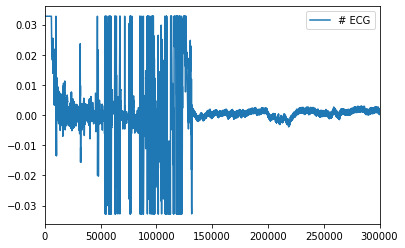

In [19]:
df.plot()
plt.xlim(0,300000)
#choose approximately 150000

(2770000, 3270000)

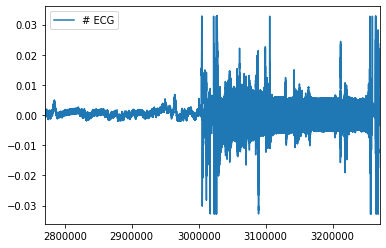

In [20]:
df.plot()
plt.xlim(2770000,3270000)
#choose approximately 2980000

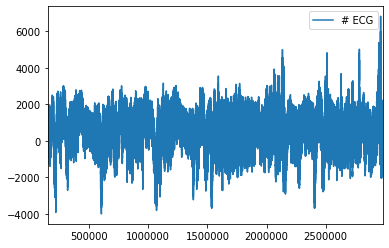

In [21]:
#truncate data to retain useful data
df = df.truncate(before = 150000, after = 2979999)
#multiply by 1000000 to better visualize data as integers
df = df*1000000
df.plot()

In [22]:
#update length of block
NUM_SAMPLES = len(df)

In [23]:
#create plots parameter
do_plot = True

In [24]:
#save as text file
np.savetxt('truncated_raw.txt',df) 

In [26]:
#save as pickle file
with open('truncated_raw.pickle','wb') as f:
    pickle.dump(df, f)

### wavelet decomposition

C:\Users\juseo\Anaconda3\lib\site-packages\pywt\_multilevel.py:45: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


Plot of wavelet decomposition for all levels


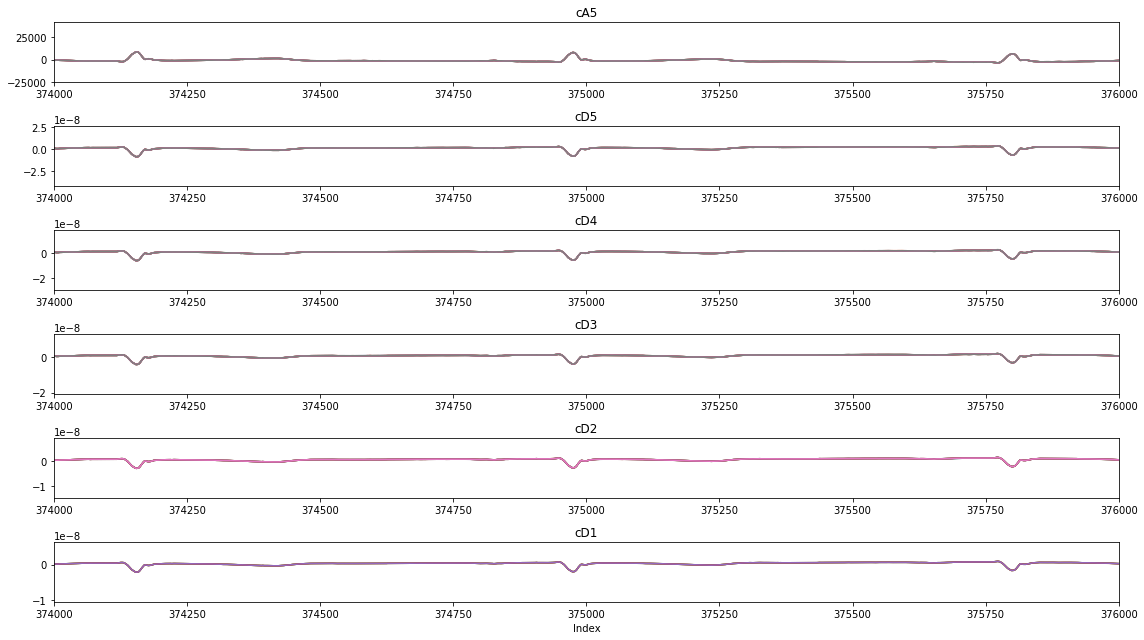

In [27]:
#do wavelet decomposition 
coeffs = wavelet_decomposition(df, do_plot)

In [28]:
#update coefficient matrix lengths
for key in coeffs.keys():
    COEFF_LENGTHS[key] = len(coeffs[key])
    
COEFF_LENGTHS

{'cA5': 2830000,
 'cD5': 2830000,
 'cD4': 2830000,
 'cD3': 2830000,
 'cD2': 2830000,
 'cD1': 2830000}

### threshold coefficients

Plot of thresholded vs unthresholded coefficients:


C:\Users\juseo\Anaconda3\lib\site-packages\ipykernel_launcher.py:111: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


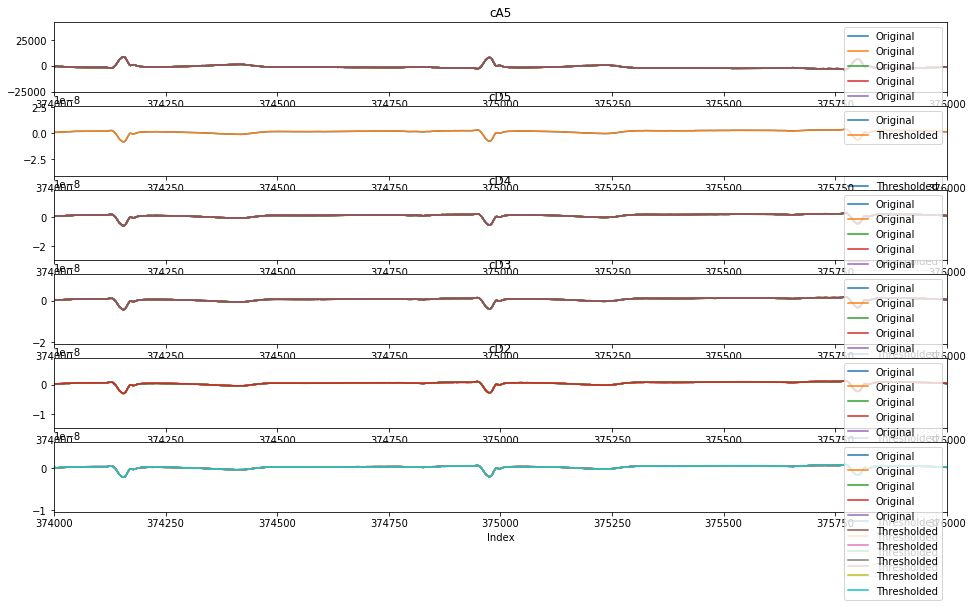

In [29]:
#threshold the coefficients using target PRD
#return nonzero thresholded coefficients, along with a binary map of zero/nonzero values
#and a list of how many nonzero values were in each set of coefficients
coeffs_thresholded, binary_map = threshold_energy(coeffs, do_plot)

### scale coefficients to [0,1] range

Plot of scaled coefficients:


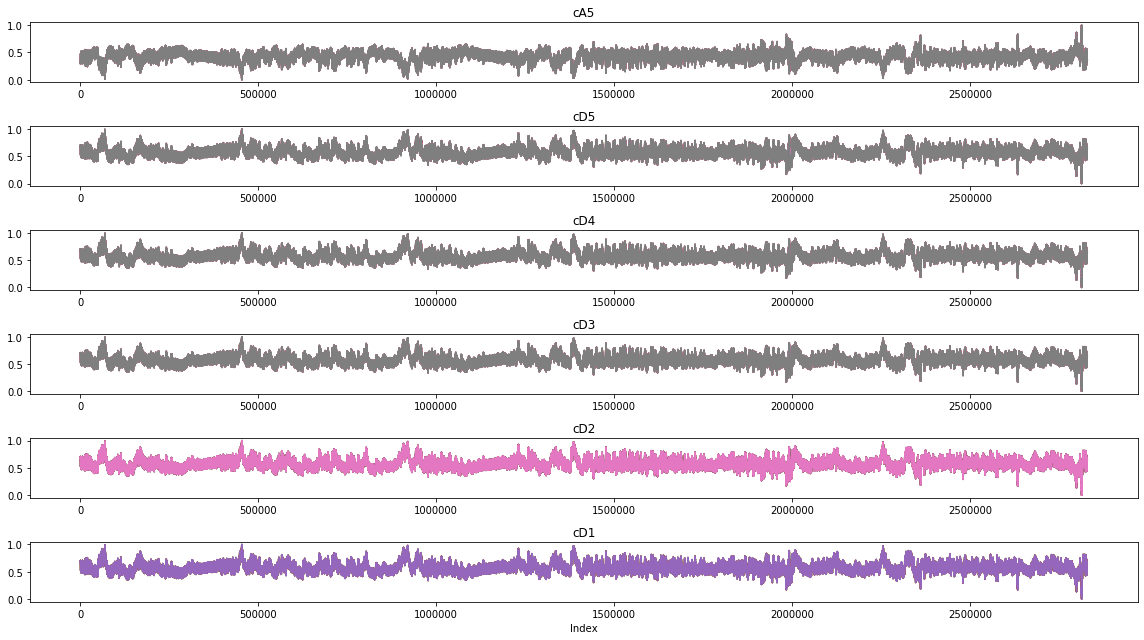

In [30]:
#scale each set of wavelet coefficients between zero and one 
#keep track of the scaling factors to re-scale to the original range in decompression
coeffs_scaled, scaling_factors = scale_coeffs(coeffs_thresholded, do_plot)

### quantize selected coefficients

Plots of reconstructed signals vs number of bits used for quantization:


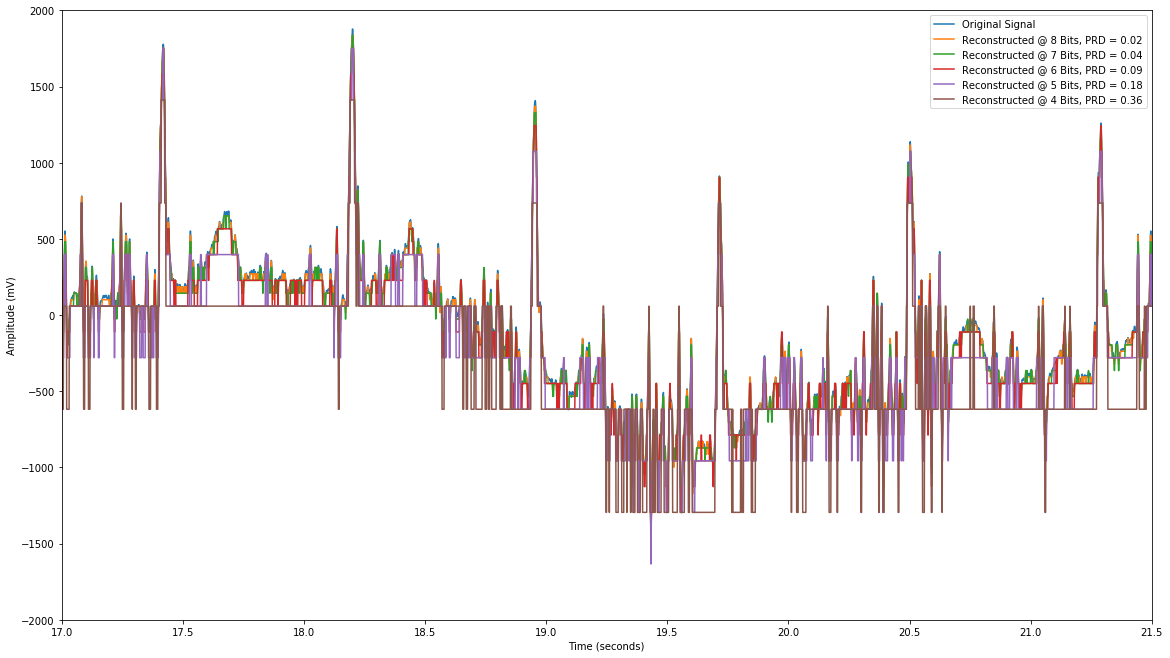

In [31]:
#choose the number of bits to quantize based on the PRD
num_bits, PRD_avg = calculate_num_bits(df, coeffs_scaled, binary_map, scaling_factors, do_plot)

In [32]:
num_bits

4

Plot of quantized coefficients:


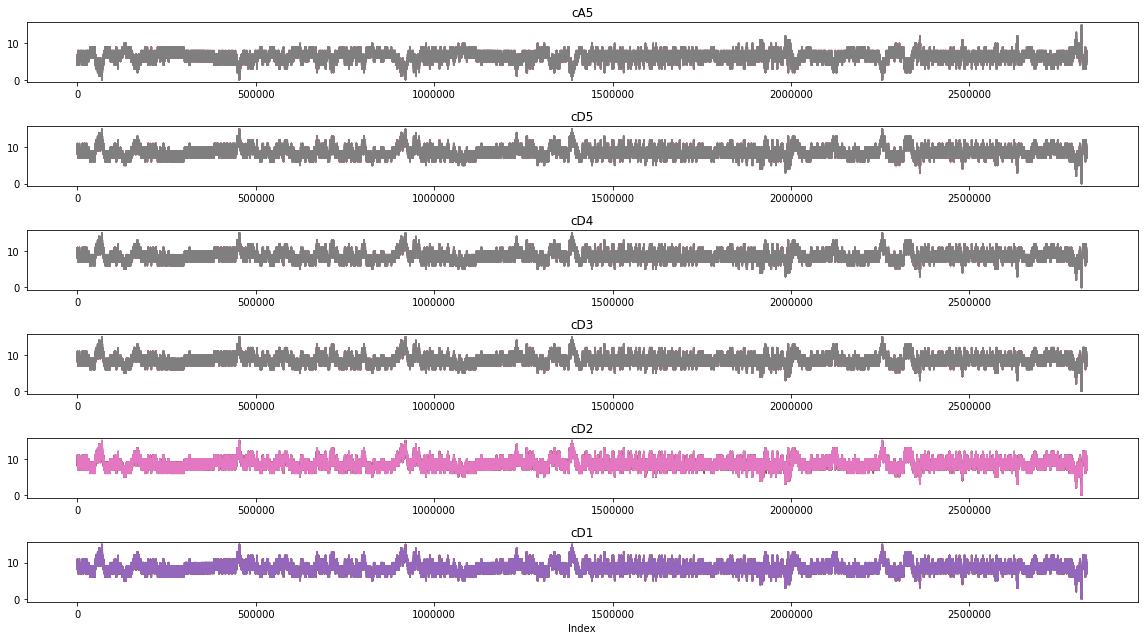

In [33]:
#get quantized coefficients
coeffs_quantized = do_quantization(coeffs_scaled, num_bits, do_plot)

### combine quantized coefficients

In [34]:
#combine all the quantized coefficients into a single array for compression
coeffs_quantized_combined = combine_coefficients(coeffs_quantized, binary_map)
#combine all the binary maps into a single array for compression
binary_map_combined = combine_coefficients(binary_map)

In [35]:
for key in binary_map.keys():
    print(key + ' ' + str(len(binary_map[key])))

cA5 2830000
cD5 2830000
cD4 2830000
cD3 2830000
cD2 2830000
cD1 2830000


In [36]:
# number of values thresholded to zero
len(binary_map_combined) - len(coeffs_quantized_combined)

454127

In [37]:
#first nonzero value in binary map
binary_map_combined.index(0)

642

In [38]:
np.where(binary_map['cA5']==0)

(array([    642,     671,     680, ..., 2829989, 2829990, 2829991],
       dtype=int64),)

### compress quantized coefficients and binary map

*to-do: add timer function to compression of coeffs*

In [40]:
#compress the quantized coefficients
coeffs_quantized_compressed, num_bits_last_byte_coeffs = compress_coefficients(coeffs_quantized_combined, num_bits)

In [41]:
#compression ratio of coefficient compression
len(coeffs_quantized_combined)/len(coeffs_quantized_compressed)

1.9999998789776565

In [42]:
#compress the binary map
binary_map_initial_state, binary_map_compressed, num_bits_last_byte_binary_map = compress_binary_map(binary_map_combined)

In [43]:
binary_map_compressed

[213,
 65,
 25,
 120,
 100,
 135,
 70,
 150,
 79,
 201,
 24,
 238,
 72,
 199,
 236,
 115,
 84,
 114,
 102,
 219,
 29,
 201,
 54,
 108,
 220,
 155,
 146,
 44,
 185,
 209,
 73,
 146,
 241,
 194,
 199,
 177,
 215,
 38,
 227,
 217,
 101,
 143,
 99,
 139,
 147,
 177,
 233,
 199,
 76,
 153,
 146,
 178,
 84,
 227,
 216,
 246,
 73,
 199,
 133,
 199,
 177,
 252,
 118,
 199,
 241,
 211,
 28,
 114,
 203,
 38,
 228,
 240,
 199,
 49,
 231,
 28,
 199,
 50,
 227,
 31,
 201,
 56,
 254,
 75,
 199,
 108,
 120,
 199,
 220,
 151,
 142,
 185,
 110,
 228,
 156,
 177,
 49,
 204,
 144,
 56,
 230,
 73,
 49,
 236,
 123,
 46,
 49,
 195,
 29,
 203,
 3,
 63,
 23,
 85,
 133,
 142,
 106,
 198,
 242,
 110,
 168,
 136,
 49,
 236,
 176,
 12,
 115,
 38,
 229,
 142,
 63,
 147,
 214,
 203,
 220,
 115,
 31,
 199,
 114,
 89,
 146,
 113,
 203,
 69,
 105,
 175,
 32,
 153,
 172,
 52,
 75,
 228,
 163,
 29,
 113,
 204,
 247,
 242,
 94,
 152,
 125,
 154,
 108,
 159,
 70,
 77,
 199,
 114,
 81,
 142,
 103,
 222,
 102,
 215,
 38,
 5

In [44]:
#binary map compression ratio
len(binary_map_combined)/len(binary_map_compressed)

111.232664932887

### save coefficients and binary map to file

In [46]:
with open('compressed_file.pickle','wb') as f:
    pickle.dump([coeffs_quantized_compressed, num_bits_last_byte_coeffs, binary_map_initial_state, binary_map_compressed, num_bits_last_byte_binary_map],f)

### calculate compression ratio

original file size:
compressed file size:
compression ratio:

### read compressed file for decompression

pickle file:

In [47]:
with open('compressed_file.pickle', 'rb') as f:
    coeffs_quantized_compressed, num_bits_last_byte_coeffs, binary_map_initial_state, binary_map_compressed, num_bits_last_byte_binary_map = pickle.load(f)

### decompression

*to-do: debug binary map decompression*

In [ ]:
#decompress the binary map
binary_map_decompressed = decompress_binary_map(binary_map_compressed, binary_map_initial_state, num_bits_last_byte_binary_map)
binary_map_decompressed

In [ ]:
#decompress the coefficients
coeffs_decompressed = decompress_coefficients(coeffs_quantized_compressed, num_bits, num_bits_last_byte_coeffs)

In [68]:
coeffs_decompressed

[[5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 [5, 5, 5, 5, 5, 5, 5, 5],
 

In [69]:
len(coeffs_decompressed)

16525873

In [70]:
#remap all the coefficients back to their original wavelet decompositions
coeffs_reconstructed = remap_coeffs(coeffs_decompressed, binary_map_decompressed)

ValueError: shape mismatch: value array of shape (16525873,8) could not be broadcast to indexing result of shape (0,)

In [ ]:
#rescale the coefficients
coeffs_unscaled = unscale_coeffs(coeffs, coeffs_reconstructed, scaling_factors, num_bits, do_plot)

In [ ]:
#do the inverse discrete wavelet transform
data_reconstructed = wavelet_reconstruction(coeffs_unscaled, data, CR_tmp, do_plot)

In [ ]:
#print the compression ratio and PRD
print('Average compression ratio: %.1f' % CR_avg)
print('Average PRD: %.3f' % PRD_avg)